# Voice opinion - par Quentin Gibon

## Introduction

L'objectif de ce projet est de mettre en place un système permettant d'analyser des avis recueillis vocalement. Par exemple on peut imaginer notre application être placée à la sortie d'une salle de cinéma, où les clients pourront donner rapidement leur avis dans un micro. Les données récoltées pourront être utilisées pour mesurer la popularité d'un film "à chaud". Nous allons pour cela tout d'abord réaliser un algorithme de reconnaissance vocale, c'est à un dire un algorithme capable de transformer un audio de voix en texte. Puis nous réaliserons de l'analyse de sentiment pour détecter si l'avis est positif ou négatif.

Ce travail se déroule en trois parties. Dans la première partie, on met en place un algorithme de speech2text. La deuxième partie consiste simplement à enregistrer la voix (l'avis cinématographique) de l'utilisateur, et à appliquer l'algorithme de la partie 1 pour transcrire l'audio enregistré. Enfin la dernière partie analyse le texte de l'avis pour connaitre sa polarité.

## Partie 1 - Speech2Text

Nous allons nous plonger dans le modèle actuel de pointe appelé Wav2vec2, développée par Facebook, en utilisant la librairie de transformateurs Huggingface en Python. Pour rappel, les transformers  sont des modèles état-de-l’art qui apprennent des représentations vectorielles à partir d’un texte d’entrée et qui dépassent les capacités humaines sur certains points. Ces modèles peuvent être pré-entraînés et sont mis à disposition par Hugging Face, une startup spécialisée dans le traitement de langage naturel.

Wav2Vec2 est un modèle pré-entraîné qui a été entraîné sur de l'audio vocal seul (auto-supervisé) et ensuite suivi d'un réglage fin sur des données vocales transcrites (LibriSpeech dataset). Il a obtenu de meilleurs résultats que de précédents modèles semi-supervisés.

De manière similaire à BERT, Wav2Vec2 encode l'audio de la parole via un réseau neuronal convolutif multicouche, puis masque des étendues des représentations latentes de la parole qui en résultent. Ces représentations sont ensuite transmises à un réseau Transformer pour construire des représentations contextualisées.

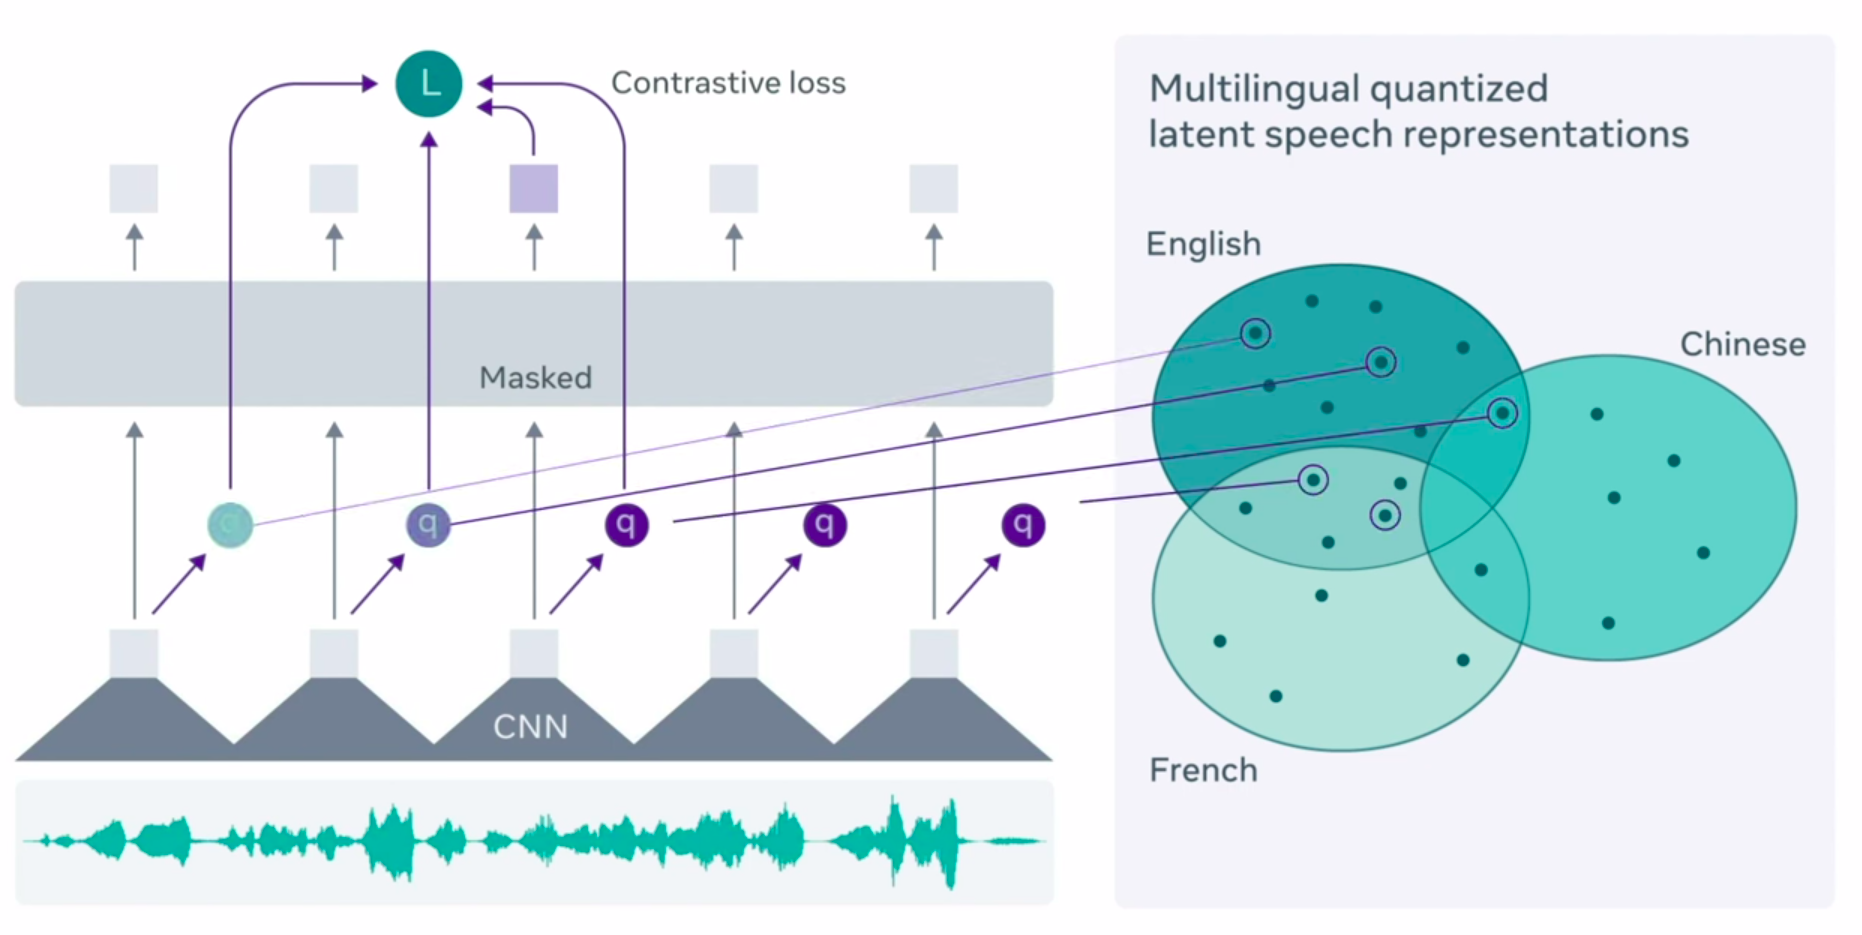

Les chercheurs de Facebook décrivent leur approche ainsi :
Des milliers de langues sont parlées dans le monde, dont un grand nombre avec plusieurs dialectes différents, ce qui représente un énorme défi pour la création d'une technologie de reconnaissance vocale de haute qualité. Il est tout simplement impossible d'obtenir des ressources pour chaque dialecte et chaque langue dans les nombreux domaines possibles (discours lu, discours téléphonique, etc.). Notre nouveau modèle, wav2vec 2.0, utilise l'autosupervision pour repousser les limites en apprenant à partir de données d'entraînement non étiquetées afin de permettre la mise en place de systèmes de reconnaissance vocale pour beaucoup plus de langues, de dialectes et de domaines. Avec seulement une heure de données d'entraînement étiquetées, wav2vec 2.0 surpasse l'état de l'art précédent sur le sous-ensemble de 100 heures du benchmark LibriSpeech - en utilisant 100 fois moins de données étiquetées.

Pour comprendre plus en détail comment fonctionne Wav2Vec : https://towardsdatascience.com/wav2vec-2-0-a-framework-for-self-supervised-learning-of-speech-representations-7d3728688cae

### Bibliothèques et modules

Dans un premier temps nous avons besoin d’installer toutes les bibliothèques et autres modules qui nous serviront pour réaliser le projet.

D'abord comme expliqué précédemment on installe la bibliothèque de transformers de Hugging Face.

In [ ]:
!pip3 install transformers==4.11.2 soundfile sentencepiece torchaudio pydub

On importe les classes du modèle Wav2Vec2 depuis les `transformers`. On utilisera également le framework de machine learning `PyTorch`.

Nous allons utiliser `torchaudio` pour charger les fichiers audio. Nous allons les utiliser les autres librairies pour enregistrer à partir du microphone en Python.
`NLTK` (Natural Language Tool Kit), est une librairie de traitement automatique du language fournissant des outils utiles pour Python.

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import torch
import soundfile as sf
# import librosa
import os
import torchaudio
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Modèle

Dans le cadre de ce travail, j'ai choisi un modèle pré entrainé adapté pour le français `facebook/wav2vec2-large-xlsr-53-french`. Il est décrit comme étant un modèle seq2seq (encodeur-décodeur) basé sur un transformer, conçu pour la reconnaissance automatique de la parole (ASR) et la traduction de la parole (ST) de bout en bout. Il utilise un sous-échantillonneur convolutif pour réduire de 3/4 la longueur des entrées vocales avant qu'elles ne soient introduites dans l'encodeur. Le modèle est entraîné avec une perte d'entropie croisée autorégressive standard et génère les transcriptions/traductions de manière autorégressive.

Wav2Vec2 a été entraîné en utilisant la classification temporelle connexionniste (CTC). La CTC est un type de sortie de réseau neuronal et une fonction de notation associée, pour l'entraînement de réseaux neuronaux récurrents (RNN) tels que les réseaux LSTM afin de résoudre les problèmes de séquence où le timing est variable. 

C'est pourquoi nous utilisons la classe Wav2Vec2ForCTC pour charger le modèle.

In [ ]:
# from transformers.models.wav2vec2.tokenization_wav2vec2 import Wav2Vec2Tokenizer
# model_name = "facebook/wav2vec2-base-960h" # 360MB
model_name = "facebook/wav2vec2-large-xlsr-53-french"

tokenizer = Wav2Vec2Tokenizer.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:423: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,


Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [ ]:
audio_url = "https://github.com/x4nth055/pythoncode-tutorials/raw/master/machine-learning/speech-recognition/30-4447-0004.wav"

### Le code

Cette fonction `correct_sentence` sert uniquement à reformater le texte en sortie pour qu'il soit "plus propre" (majuscule en début de phrase etc).

In [ ]:
def correct_sentence(input_text):
    sentences = nltk.sent_tokenize(input_text)
    return (' '.join([s.replace(s[0],s[0].capitalize(),1) for s in sentences]))

`get_transcription` est notre fonction principale. Elle prend en entrée un fichier audio format .wav et sort le texte reconnu.

Dans un premier temps, **on prépare le fichier audio** reçu pour pouvoir y appliquer notre modèle :

La fonction `torchaudio.load()` charge le fichier audio et retourne l'audio comme un vecteur, et le taux d'échantillonnage, il télécharge aussi automatiquement le fichier si c'est une URL. Si c'est un chemin dans le disque, il le chargera aussi.

Notez que nous utilisons également la méthode `squeeze()`, qui consiste à supprimer les dimensions de taille 1, c'est-à-dire à convertir le tenseur de (1, 274000) en (274000,).

Ensuite, nous devons nous assurer que le fichier audio d'entrée du modèle a une fréquence d'échantillonnage de 16000Hz, car wav2vec2 est entraîné sur cette fréquence. On utilise pour cela le resampler de `torchaudio.transforms`, qui nous aide à convertir le fichier audio chargé à la volée d'un taux d'échantillonnage à un autre.

Avant de faire l'inférence, nous passons le vecteur audio au tokenizer wav2vec2. On spécifie le `sampling_rate` et on passe `"pt"` à l'argument `return_tensors` pour obtenir des tenseurs PyTorch dans les résultats.

Ceci fait, on peut passer le vecteur dans notre modèle, et **réaliser une inférence**.

Finalement on passe les logits à `torch.argmax()` pour obtenir la prédiction probable. Puis on les décode avec `tokenizer.decode()` pour retourner du texte (que l'on traite un minimum avec `correct_sentence`.

In [ ]:
def get_transcription(audio_path):
  # load our wav file
  speech, sr = torchaudio.load(audio_path)
  speech = speech.squeeze()
  # or using librosa
  # speech, sr = librosa.load(audio_file, sr=16000)
  # resample from whatever the audio sampling rate to 16000
  resampler = torchaudio.transforms.Resample(sr, 16000)
  speech = resampler(speech)
  # tokenize our wav
  input_values = tokenizer(speech, return_tensors="pt", sampling_rate=16000)["input_values"]
  # perform inference
  logits = model(input_values)["logits"]
  # use argmax to get the predicted IDs
  predicted_ids = torch.argmax(logits, dim=-1)
  # decode the IDs to text
  transcription = tokenizer.decode(predicted_ids[0])
  return correct_sentence(transcription.lower())

## Partie 2 - La parole est à vous

La partie de code ci-dessous permet d'enregistrer un audio. Choisissez la durée d'enregistrement, lancez le code et vous obtiendrez un bouton pour commencer à enregistrer.



In [ ]:
!git clone -q --depth 1 https://github.com/snakers4/silero-models

%cd silero-models

/content/silero-models


In [ ]:
from IPython.display import Audio, display, clear_output
from colab_utils import record_audio
import ipywidgets as widgets
from scipy.io import wavfile
import numpy as np


record_seconds =   10#@param {type:"number", min:1, max:10, step:1}
sample_rate = 16000

def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds)
  display(Audio(audio, rate=sample_rate, autoplay=True))
  wavfile.write('recorded.wav', sample_rate, (32767*audio).numpy().astype(np.int16))

button = widgets.Button(description="Record Speech")
button.on_click(_record_audio)
display(button)

Starting recording for 10 seconds...


<IPython.core.display.Javascript object>

Finished recording!


Maintenant vous pouvez évaluer l'efficacité de l'algorithme en passant votre nouvel enregistrement à la fonction `get_transcritpion`. (Il y a une petite faute d'orthographe à "film", mais ce n'est pas dérangeant).

In [ ]:
# get the transcription of the recorded audio
comment = get_transcription("recorded.wav")
print(comment)

"J'ai beaucoup aimé ce filme et toute ma famille a aimé aussi"

## Partie 3 - Analyse du commentaire

Pour commencer, on installe les librairies que l'on va utiliser.

In [ ]:
!pip install datasets
import numpy as np
import pandas as pd
from datasets import load_dataset
import tensorflow as tf

Nous allons utiliser un dataset qui contient des commentaires laissés par les internautes sur Allociné : [ici](https://huggingface.co/datasets/allocine). On charge le dataset avec la librairy d'Hugging face prévue à cet effet `datasets`, on peut directement séparer dans des variables les données d'entrainement, de test et de validation.
On sépare les données "review" qui sont les commentaires, de leur "label" (0 pour négatif, 1 pour positif).

In [ ]:
train, val, test = load_dataset(
    'allocine', 
    split=['train', 'validation', 'test']
)
# Reviews need to be tokenized
train_reviews = np.array(train['review'])
val_reviews = np.array(val['review'])
test_reviews = np.array(test['review'])

train_labels = train['label']
val_labels = val['label']
test_labels = test['label']

On charge le modèle pour la détéction de sentiments et son tokenizer. Nous allons utiliser [CamemBERT](https://huggingface.co/docs/transformers/model_doc/camembert), un modèle de NLP de type BERT en français. C'est une ressource très utile pour les praticiens en NLP qui travaillent avec des textes en français. BERT est suffisamment sophistiqué pour analyser le sens de toutes les nuances du langage et ne nécessit pas de récourir aux étapes de pre-processing telles que la suppression des stop words, le stemming et les transformations en minuscules.

`TFCamembertForSequenceClassification` est le modèle qui correspond à ce que l'on veut faire (analyse de sentiment).

In [ ]:
from transformers import TFCamembertForSequenceClassification, CamembertTokenizer

model = TFCamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels = 2)
tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base')

On va maintenant formatter nos données pour qu'elle puisse entrainer notre modèle.

Cela passe d'abord par l'encodage du texte (tokenization). Pour pouvoir passer nos données au modèle, il va falloir qu’elles soient encodées. Encoder, c’est donner une représentation numérique (en vrai vectorielle) au texte exactement comme le fait un embedding classique.

A noter qu'on n'utilisera que les 2000 premiers commentaires du dataset d'entrainement, pour avoir une chance de finir rapidement ce projet.

In [ ]:
def encode_reviews(tokenizer, reviews, max_length):
    token_ids = np.zeros(shape=(len(reviews), max_length),
                         dtype=np.int32)
    for i, review in enumerate(reviews):
        encoded = tokenizer.encode(review, max_length=max_length)
        token_ids[i, 0:len(encoded)] = encoded
    attention_mask = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_mask": attention_mask}

In [ ]:
MAX_SEQ_LEN = 400 # in terms of generated tokens (not words)
encoded_train = encode_reviews(tokenizer, train_reviews[:2000], MAX_SEQ_LEN)
encoded_valid = encode_reviews(tokenizer, val_reviews, MAX_SEQ_LEN)
encoded_test = encode_reviews(tokenizer, test_reviews, MAX_SEQ_LEN)

In [ ]:
y_train = np.array(train_labels[:2000])
y_val = np.array(val_labels)
y_test = np.array(test_labels)

Nous utiliserons Adam comme otptimizer, SparseCategoricalCrossentropy comme fonction de perte et SparseCategoricalAccuracy comme mesure de précision. Le fine-tuning du modèle pendant 2 epochs nous donnera une précision d'environ 95 %, ce qui est déjà très bien.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=5e-6, epsilon=1e-08)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)    

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

In [ ]:
X_train, y_train = preprocessor.fit_transform(
    train_reviews[:size], train_labels[:size]
)
X_val, y_val = preprocessor.transform(val_reviews, val_labels)
X_test, y_test = preprocessor.transform(test_reviews, test_labels)

Entrainer le modèle m'a pris environ 1h (sur google collab). C'est sans doute trop long, jouer avec les paramètres permettrait probablement d'être plus efficace. Mais nous allons garder ce modèle dans ce cas.

In [ ]:
history = model.fit(
    encoded_train, y_train, epochs=2, batch_size=4, 
    validation_data=(encoded_valid, y_val), verbose=1
)

Epoch 1/2
500/500 [==============================] - 1922s 4s/step - loss: 0.3454 - accuracy: 0.8980 - val_loss: 0.2030 - val_accuracy: 0.9377
Epoch 2/2
500/500 [==============================] - 1951s 4s/step - loss: 0.1618 - accuracy: 0.9535 - val_loss: 0.1430 - val_accuracy: 0.9544


Nous devons tokeniser nos critiques avec notre tokeniseur BERT pré-entraîné. Nous allons ensuite alimenter notre modèle avec ces séquences tokénisées et exécuter une couche finale de softmax pour obtenir la prédiction. Nous pouvons ensuite utiliser la fonction argmax pour déterminer si notre prédiction de sentiment pour la critique est positive ou négative. Enfin, nous imprimerons le résultat, et ça fonctionne ! Très bien même !

In [ ]:
tf_batch = tokenizer(comment, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negatif','Positif']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
print(comment, ": \n", labels[label[0]])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


J'ai beaucoup aimé ce filme et toute ma famille a aimé aussi : 
 Positif




---

## Références
https://www.analyticsvidhya.com/blog/2021/09/ok-google-speech-to-text-in-python-with-deep-learning-in-2-minutes/

https://www.thepythoncode.com/article/speech-recognition-using-huggingface-transformers-in-python

https://en.wikipedia.org/wiki/Connectionist_temporal_classification

https://maelfabien.github.io/machinelearning/wav2vec/#5-the-code

https://huggingface.co/docs/transformers/model_doc/wav2vec2

https://huggingface.co/datasets/allocine

https://ledatascientist.com/analyse-de-sentiments-avec-camembert/

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

https://huggingface.co/docs/datasets/use_dataset.html

https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/blob/master/03_bert.ipynb